## Importing the necessary packages

In [32]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Reader, Dataset
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from surprise.accuracy import rmse
from surprise.model_selection import cross_validate
from scipy.sparse import csr_matrix
import seaborn as sns

In [33]:
links= pd.read_csv('links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [34]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


In [35]:
links.isna().sum()

movieId    0
imdbId     0
tmdbId     8
dtype: int64

In [36]:
movies= pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [37]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [38]:
ratings= pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [39]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [40]:
tags= pd.read_csv('tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [41]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [42]:
#Merge movies and ratings dataframes for easier reference.
df = pd.merge(ratings, movies, on='movieId')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [43]:
# Drop unnecessary columns
df = df.drop("timestamp", axis=1)
df.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [44]:
#See which movie Ids have the highest number of views
df['movieId'].value_counts()

movieId
356       329
318       317
296       307
593       279
2571      278
         ... 
86279       1
86922       1
5962        1
87660       1
163981      1
Name: count, Length: 9724, dtype: int64

In [45]:
#See which users have provided the most ratings
df['userId'].value_counts()

userId
414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
431      20
194      20
257      20
207      20
189      20
Name: count, Length: 610, dtype: int64

In [46]:
#View the distribution of ratings 
df['rating'].value_counts()

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

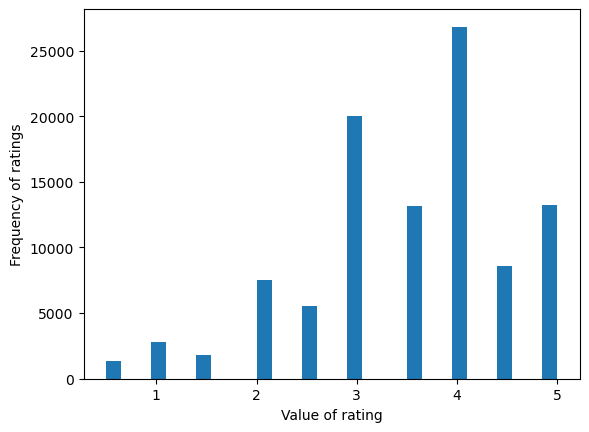

In [47]:
#Plot a histogram of the frequency of certain rating values
plt.hist(df['rating'],bins=30)
plt.xlabel('Value of rating')
plt.ylabel('Frequency of ratings')
plt.show()

In [48]:
# Look at how many times each movie has been watched
df.groupby('title').size().sort_values(ascending=False)

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
                                            ... 
King Solomon's Mines (1950)                    1
King Solomon's Mines (1937)                    1
King Ralph (1991)                              1
King Kong Lives (1986)                         1
À nous la liberté (Freedom for Us) (1931)      1
Length: 9719, dtype: int64

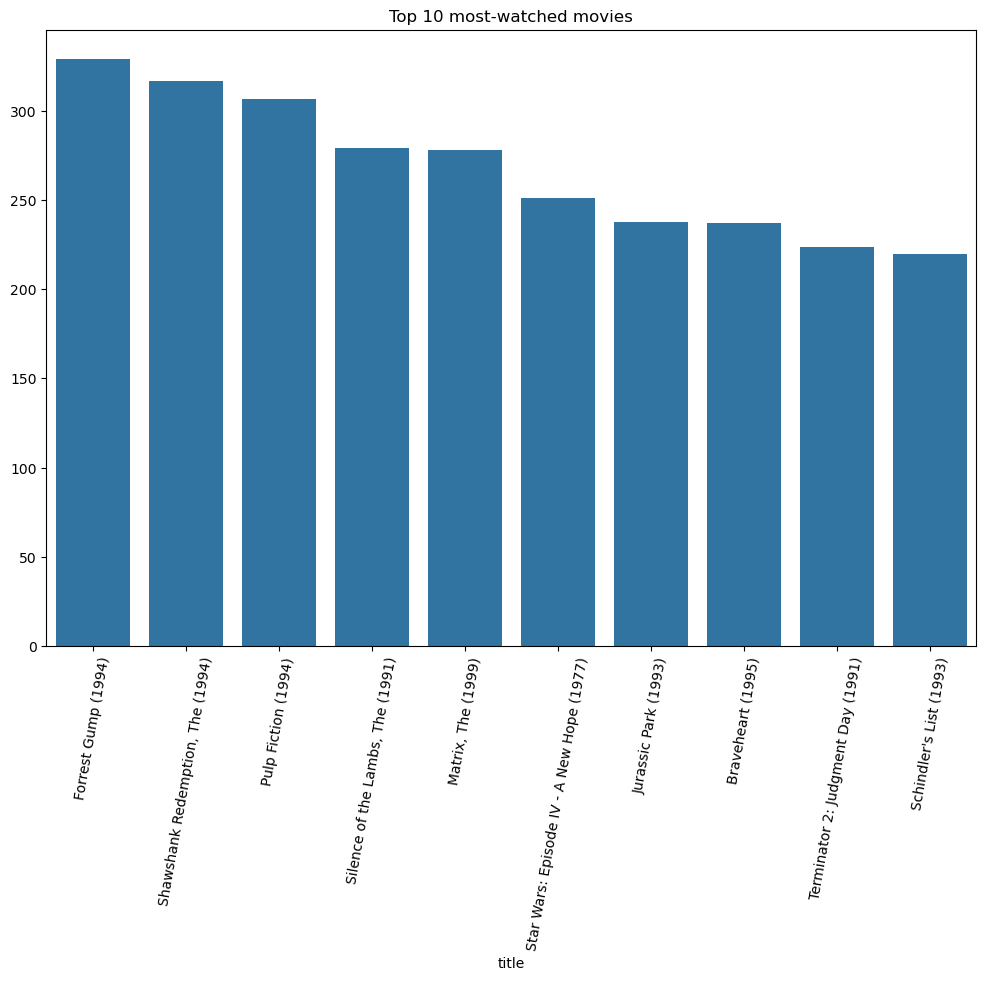

In [49]:
#Plot the top 10 most watched movies
plt.figure(figsize=(12, 8))
topmovies = df.groupby('title').size().sort_values(ascending=False).head(10)
sns.barplot(x=topmovies.index, y=topmovies.values)
plt.title('Top 10 most-watched movies')
plt.xticks(rotation=80)
plt.show()

In [50]:
#Creat genre labels
genrelabels = set()
for i in df['genres'].str.split('|').values:
    genrelabels = genrelabels.union(set(i))

In [51]:
#Print genres
genrelabels

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [52]:
#Create function that counts how many movies there are of each genre 
def genrecounts(df, col, labels):
    count = dict()
    for i in labels: count[i] = 0
    for value in df[col].str.split('|'):
        if type(value) == float and pd.isnull(value): continue
        for i in value: 
            if pd.notnull(i): count[i] += 1
    return count                                       


In [53]:
#Apply the genrecounts formula to our dataset and print the resulting genres and their counts 
genre_count = genrecounts(df, 'genres', genrelabels)
genre_count

{'Fantasy': 11834,
 'Romance': 18124,
 'Western': 1930,
 'Documentary': 1219,
 'Comedy': 39053,
 'Children': 9208,
 'Thriller': 26452,
 'Mystery': 7674,
 'Adventure': 24161,
 'Action': 30635,
 'Animation': 6988,
 'IMAX': 4145,
 '(no genres listed)': 47,
 'Sci-Fi': 17243,
 'Crime': 16681,
 'Musical': 4138,
 'Horror': 7291,
 'Film-Noir': 870,
 'Drama': 41928,
 'War': 4859}

In [54]:
#Create a dataframe for the genres and their value counts 
genres = pd.DataFrame(list(genre_count.items()),columns = ['Genre','Frequency'])
#Sort the DataFrame
genres = genres.sort_values(by=['Frequency'], ascending=False)
#Print the resulting DataFrame 
genres.head()

,Genre,Frequency
18,Drama,41928
4,Comedy,39053
9,Action,30635
6,Thriller,26452
8,Adventure,24161


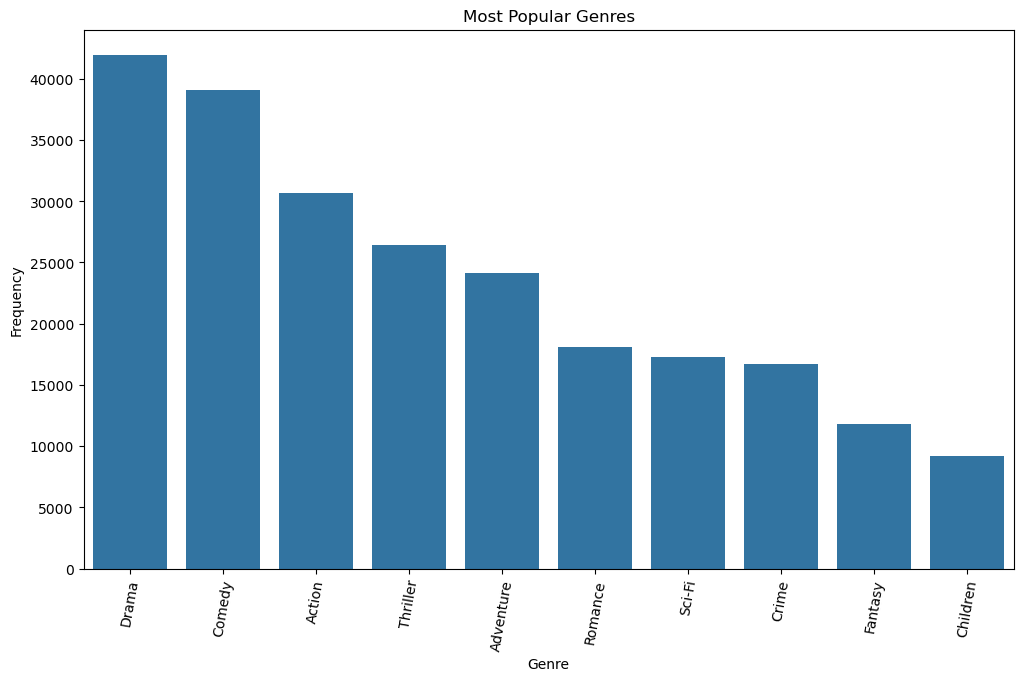

In [55]:
#Plot the top most watched movie genres
plt.figure(figsize=(12, 7))
top_genres = genres.head(10)  # Select the top 10 genres
sns.barplot(x=top_genres['Genre'], y=top_genres['Frequency'])
plt.title('Most Popular Genres')
plt.xticks(rotation=80)
plt.show()

In [56]:
df.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [57]:
new_df = df[['userId', 'movieId', 'rating']]
new_df.head()

,userId,movieId,rating
0,1,1,4.0
1,5,1,4.0
2,7,1,4.5
3,15,1,2.5
4,17,1,4.5


In [58]:
from surprise import Reader, Dataset
# read in values as Surprise dataset 
reader = Reader()

# Load the dataset from the dataframe
data = Dataset.load_from_df(new_df, reader)

In [59]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


## Determine the best model
Now, compare the different models and see which ones perform best. For consistency sake, use RMSE to evaluate models. Remember to cross-validate! Can you get a model with a higher average RMSE on test data than 0.869?


In [60]:
#Instantiate the SVD model
svd = SVD()

In [61]:
# Returning 5 cross-validated iterations 
cv_svd = cross_validate(SVD(), data, cv=5, n_jobs=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8789  0.8725  0.8678  0.8733  0.8675  0.8720  0.0042  
MAE (testset)     0.6764  0.6718  0.6669  0.6684  0.6662  0.6700  0.0038  
Fit time          2.17    2.11    2.02    1.95    1.89    2.03    0.10    
Test time         0.33    0.32    0.32    0.37    0.33    0.34    0.02    


In [62]:
## Perform a gridsearch with SVD
params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
g_s_svd.fit(data)


In [63]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8689731475748834, 'mae': 0.668654966359443}
{'rmse': {'n_factors': 50, 'reg_all': 0.05}, 'mae': {'n_factors': 50, 'reg_all': 0.05}}


In [64]:
from surprise.model_selection import cross_validate
# cross validating with KNNBasic
knn_basic = KNNBasic()

# Perform cross-validation
cv_results = cross_validate(knn_basic, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9623  0.9545  0.9530  0.9566  0.0041  
MAE (testset)     0.7373  0.7320  0.7302  0.7332  0.0030  
Fit time          0.24    0.23    0.22    0.23    0.01    
Test time         3.12    2.76    2.95    2.94    0.15    


In [65]:
# print out the average RMSE score for the test set
print("Average RMSE score for the test set:", cv_results['test_rmse'].mean())

Average RMSE score for the test set: 0.9566104111253942


In [66]:
# cross validating with KNNBaseline
for measure in ['test_rmse', 'test_mae']:
    print(f'{measure}: {cv_results[measure].mean()}')

test_rmse: 0.9566104111253942
test_mae: 0.7331895493456236


In [67]:
# print out the average score for the test set
print("Average RMSE score for the test set:", cv_results['test_rmse'].mean())

Average RMSE score for the test set: 0.9566104111253942


## Making Recommendations
It's important that the output for the recommendation is interpretable to people. Rather than returning the movie_id values, it would be far more valuable to return the actual title of the movie. As a first step, let's read in the movies to a dataframe and take a peek at what information we have about them.



In [68]:
new_df.head()

,userId,movieId,rating
0,1,1,4.0
1,5,1,4.0
2,7,1,4.5
3,15,1,2.5
4,17,1,4.5


## Making simple predictions
Just as a reminder, let's look at how you make a prediction for an individual user and item. First, we'll fit the SVD model we had from before.



In [69]:
svd = SVD(n_factors= 50, reg_all=0.05)
svd.fit(dataset)

In [70]:
svd.predict(2, 4)

Prediction(uid=2, iid=4, r_ui=None, est=3.130560872837071, details={'was_impossible': False})

This prediction value is a tuple and each of the values within it can be accessed by way of indexing. Now let's put our knowledge of recommendation systems to do something interesting: making predictions for a new user!

## Obtaining User Ratings
It's great that we have working models and everything, but wouldn't it be nice to get to recommendations specifically tailored to your preferences? That's what we'll be doing now. The first step is to create a function that allows us to pick randomly selected movies. The function should present users with a movie and ask them to rate it. If they have not seen the movie, they should be able to skip rating it.

The function movie_rater() should take as parameters:

movie_df: DataFrame - a dataframe containing the movie ids, name of movie, and genres
num: int - number of ratings
genre: string - a specific genre from which to draw movies
The function returns:

rating_list : list - a collection of dictionaries in the format of {'userId': int , 'movieId': int , 'rating': float}
This function is optional, but fun :)


In [71]:
def movie_rater(movie_df,num, genre=None):
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list

In [83]:
# try out the new function here!
user_rating = movie_rater(df, 4, 'Comedy')

       userId  movieId  rating                               title  \
56456     305    79702     3.0  Scott Pilgrim vs. the World (2010)   

                                      genres  
56456  Action|Comedy|Fantasy|Musical|Romance  
       userId  movieId  rating                  title  genres
28582     266      135     1.0  Down Periscope (1996)  Comedy
       userId  movieId  rating                     title          genres
63306     474     3258     2.5  Death Becomes Her (1992)  Comedy|Fantasy
       userId  movieId  rating                          title  genres
94531     599    49220     1.5  For Your Consideration (2006)  Comedy


If you're struggling to come up with the above function, you can use this list of user ratings to complete the next segment


In [80]:
user_rating

[{'userId': 1000, 'movieId': 2375, 'rating': ''},
 {'userId': 1000, 'movieId': 71520, 'rating': ''},
 {'userId': 1000, 'movieId': 97921, 'rating': ''},
 {'userId': 1000, 'movieId': 4175, 'rating': ''}]

## Making Predictions With the New Ratings

Now that you have new ratings, you can use them to make predictions for this new user. The proper way this should work is:

add the new ratings to the original ratings DataFrame, read into a surprise dataset
train a model using the new combined DataFrame
make predictions for the user
order those predictions from highest rated to lowest rated
return the top n recommendations with the text of the actual movie (rather than just the index number)

In [91]:
import pandas as pd
from surprise import Dataset, Reader

# Assuming user_rating is a dictionary containing user ratings
user_ratings = pd.DataFrame(user_rating)

# Selecting only relevant columns from the original DataFrame 'ratings'
ratings_subset = ratings[['userId', 'movieId', 'rating']]

# Concatenating the original ratings DataFrame with the new user ratings DataFrame
new_ratings_df = pd.concat([ratings_subset, user_ratings], axis=0)

# Preprocess 'rating' column to handle empty strings
new_ratings_df['rating'] = new_ratings_df['rating'].replace('', pd.NA)

# Define the Reader object
reader = Reader(rating_scale=(0.5, 5))

# Load dataset from DataFrame, handling missing values
new_data = Dataset.load_from_df(new_ratings_df.dropna(), reader)


In [90]:
# train a model using the new combined DataFrame
svd_ = SVD(n_factors= 50, reg_all=0.05)
svd_.fit(new_data.build_full_trainset())